<h1>TMA4320 - Blind Source Sepparation with Independent Component Analysis</h1>
<p>Notebook and associated data and source code is hosted at: <a href="https://github.com/kaprests/TMA4320-project1">GitHub</a></p>
<h3>Gruppe 21 - K.A. Prestsveen og H.V. Skaldebø<h3>
<h2>Abstract</h2>
<p>This notebook is the first project in TMA4320 at the Norwegian University of Science and Technology. It describes the basic principles of independent component analysis, and demonstrates it by sepparating mixed sound signals into separate, distinguishable components.</p>

<h2>1 - Introduction</h2>
The purpose of this project is to simulate the Cocktail party effect(CPE) with blind source sepparation, using independent component analysis (ICA). The CPE is a psychological effect allowing the human brain to distinguish conversations or sounds from e.g. a noisy room with several different sound sources. The noisy room is simulated with  a provided audiomix of three sources which is sepparated into independent, distinguishable sound clips using ICA. 

Each signal $j$ of length $T$ is described by a function $s_{j}(t),$ $t  \epsilon [0,T]$ at time $t$. Combining the signals with weights $a_{ij}$, depending upon the distance from the source, one gets a linear combination $x_{i}$ describing the mixed sound recorded of microphone *i*. In this notebook the number of sources $j$ is assumed to be equal to the number of microphones $i$, making things a little simpler.

$$x_{i}(t) = a_{i1}s_{1}(t) + ... + a_{id}s_{d}(t), i = 1, 2, ... , n$$

With a digital signal each source and recording will be described by a discrete, sampled signal instead of a continious function like above. The sampled signals from all the sources and the recorded audio of all the microphones can then be described with the $dxN$ matrixes <b>s</b> and <b>x</b>, with $d$ being the number of sources or microphones and $N$ the number of discrete signals determined by the length of the sound clip (s) times the sample rate (Hz).

$$ \mathbf{s} = \begin{bmatrix}
    s_{1}(t_{0}) & \dots & s_{1}(t_{N}) \\
    s_{2}(t_{0}) & \dots & s_{2}(t_{N}) \\
    . & \dots & . \\
    . & \dots & . \\
    . & \dots & . \\
    s_{d}(t_{0}) & \dots & s_{d}(t_{N})
\end{bmatrix}
,  \mathbf{x} = \begin{bmatrix}
    x_{1}(t_{0}) & \dots & x_{1}(t_{N}) \\
    x_{2}(t_{0}) & \dots & x_{2}(t_{N}) \\ 
    . & \dots & . \\
    . & \dots & . \\
    . & \dots & . \\
    x_{d}(t_{0}) & \dots & x_{d}(t_{N})
\end{bmatrix}
$$

The number of sources and microphones $d$ will typically be a very small number compared to $N$, for the audio signals used here $d = 3$ and $N = 5000$. The matrix **A** containing the weights $a_{ij}$ is not displayed.


<h2>Independent Component Analysis</h2>
<b>This is just a very brief review of the basic ideas behind ICA, which is more thoroghly explained in "Independent component analysis: algorithms and applications"<a href="#article" id="article"><sup>2</sup></a></b>.

Independent component analysis is, as the name suggests, a way to unmix and reconstruct the original signals given signals mixed in an arbitrary or unknown way. An important assumtion of the method is that the signals are statistically independent, and so the analysis is not expected to work if this is not fullfilled. It is also assumed that the signals are non-gaussian, meaning they are not distributed according to the normaldistribution.

The goal is to find an "unmix matrix" $W$ which essentially tries to transform the mixed data back into something resembling the original, unmixed signals, and since the original signals are assumed to be non-gaussian, the idea is to maximize the non-gaussianity of $y(t)$.

$$ \mathbf{y(t)} = \begin{bmatrix}
    W_{1,1} & \dots & W_{1,d} \\
    s_{2,1} & \dots & W_{2,d} \\
    . & \dots & . \\
    . & \dots & . \\
    . & \dots & . \\
    W_{d,1} & \dots & W_{d,d}
\end{bmatrix}
.
\begin{bmatrix}
    x_{1}(t_{0}) & \dots & x_{1}(t_{N}) \\
    x_{2}(t_{0}) & \dots & x_{2}(t_{N}) \\ 
    . & \dots & . \\
    . & \dots & . \\
    . & \dots & . \\
    x_{d}(t_{0}) & \dots & x_{d}(t_{N})
\end{bmatrix}
$$

Kurtosis and negentropy are two different measurments of non-gaussianity, and to maximize the non-gaussianity of y(t), the algorithm maximizes the kurtosis or negentropy of the unmix matrix $W$.

<h2>2 - The Algorithm</h2>

<h2>2.1 - Preparations</h2>

Firsly we need to import the data (sound files) that we will be working with and make them playable. The three cells below uploads the provided sound files, utilising the provided script "wav_file_loader.py", and the files are assumed to be placed in <b>.audio/</b>.


In [ ]:
'''This cell uploads the files that are to be decomposed.'''

import numpy as np
from wav_file_loader import read_wavefiles

paths = ['audio/mix_1.wav', 'audio/mix_2.wav', 'audio/mix_3.wav']
data, sampling_rate = read_wavefiles(paths)
num_signals = data.shape[0]

In [ ]:
'''This cell normalizes the signals to a common volume level.'''

def normalize_audio(data):
    # Scale amplitude s.t. max(data[i]) == 1.
    abs_data = np.absolute(data)
    maximums = np.amax(abs_data,1)
    
    # Divide each row by a different vector element:
    data = data / maximums.reshape((3,1))
    return data

data = normalize_audio(data)

The output widgets of the cells below allows playback of the provided mixed audio.

In [ ]:
'''This cell makes widgets for playing the uploaded clips.'''

import IPython.display as ipd

for i in range(data.shape[0]):
    ipd.display(ipd.Audio(data[i,:], rate=sampling_rate))

<h2>2.2 - Mixing</h2>

The cells in this section is for mixing sepparate, clear audio into noisy clips. This is used to create some custom clips to further test the algorithm.

In [ ]:
def normalize_rowsums(A):
    '''
    Divides each row in A by its sum.
    The sum of each row in the result is 1.0.
    '''
    
    the_sum = np.sum(A,1)
    A = A / the_sum.reshape((3,1))
    return A

def random_mixing_matrix(signals, observations):
    '''
    Creates a random matrix
    Each element is a small positive number, not too close to 0.
    (1/11, 5/7).
    '''
    
    A = 0.25 + np.random.rand(observations, signals)
    return normalize_rowsums(A)


In [ ]:
A = random_mixing_matrix(num_signals, num_signals)
data_mixed = normalize_audio(A @ data)

Again, the widgets outputed by the cell below allows playback of the provided mixed audio.

In [ ]:
for i in range(data.shape[0]):
    ipd.display(ipd.Audio(data[i,:], rate=sampling_rate))

<h2>2.3 - Custom Sound Clips</h2>

The cell below combines the functions from the above two sections(2.1 and 2.2) to upload and mix some audio of our own, and makes the resulting mix playable using the outputted widgets. This is decomposed together with the provided audio when the algorithm is run.

In [ ]:
paths1 = ['audio/clip1.wav', 'audio/clip2.wav', 'audio/clip3.wav']
data1, sampling_rate1 = read_wavefiles(paths1)
num_signals1 = data1.shape[0]

B = random_mixing_matrix(num_signals1, num_signals1)
data_mixed1 = normalize_audio(B @ data1)

for i in range(data1.shape[0]):
    ipd.display(ipd.Audio(data_mixed1[i,:], rate=sampling_rate1))

<h2>2.4 - Preprocessing</h2>

The following cell contains the preprocessing functions <font color='blue'> center_rows() </font> and <font color='blue'> whiten_rows() </font>. The absolute value of the signals does not matter, and thus we can make calculations easier by transforming the data so that the signals oscillates around an expected value of zero. The first function <font color='blue'> center_rows() </font> takes care of this by subtracting the mean of each row $x_{j}(t_{i})$ from the inputed matrix containing the sampled data, as described in equation \ref{ligning2 :p}.

** Ligning to fra beskrivelsen **

er en diskret variabel, dvs

så modifiserer vi hvert av
signalene slik

Dette gjør vi med hver av de
d
radene i
x
og får ut en såkalt sentrert
versjon av dataene.  For å unngå å lage mye unødvendig notasjon, så
antar vi i det videre at matrisen
x
er slik at radene summerer seg til 0,
dvs de er blitt sentrert.

In [ ]:
def center_rows(Z):
    """
    Ensures each row has zero mean.
    Takes a matrix of arbitrary shape and subtracts from each row the mean value of that row.
    """
    
    # The code returns a dxN-matrix, say Zc, where each row has zero mean
    row_means = np.mean(Z, axis=1)
    Z_transposed = Z.transpose()
    Zc_transposed = Z_transposed - row_means
    Zc = Zc_transposed.transpose()
    return Zc #, mus


def whiten_rows(Z):
    """
    Return whitened version of Z and the matrix for the transform, say Zw, T, where Zw=T*Z
    """
    
    # Covariance matrix, C
    C = np.cov(Z)
    
    # The following two statements compute T (inverse square root of C).
    U, S, _ = np.linalg.svd(C, full_matrices=False)
    T  = U @ np.diag(1 / np.sqrt(S)) @ U.T
    
    # Finally the withened version of Z, Zw
    Zw = np.matmul(T,Z)
    
    return Zw, T

<h2>2.5 - Main Iteration - Maximization of Non-gaussianity(??)</h2>

In [ ]:
def normalize_rownorms(Z):
    """
    Divides each row in matrix Z by its Euclidean norm, 
    so that he norm of each row in the output is equal to one.
    
    It first computes the Euclidean norm of each row of the input matrix Z,
    then scales each row by this norm. 
    """
     
    e_norms = np.linalg.norm(Z, axis=1)
    Z_trans = Z.transpose()
    Z_norm_trans = Z_trans / e_norms
    Z_norm = Z_norm_trans.transpose()
    return Z_norm

In [ ]:
def decorrelate_weights(W):
    """
    This is the orthogonalization step (or decorrelation step) The dxd input matrix W is projected onto an 
    orthogonal matrix by the transformation Wd = (WW^T)^{-1/2} W as described in the note. The single output 
    argument is the projected W-matrix (Wd).
    
    Uses a similar technque for computing the inverse square root as in the whitening step.
    """
    
    # Matrix product of W and its transposed
    WW_T = np.matmul(W,W.transpose())
    
    # Computes T, the inverse square root of WW_T
    U, S, _ = np.linalg.svd(WW_T, full_matrices=False)
    T = U @ np.diag(1 / np.sqrt(S)) @ U.transpose()
    
    # Finally computes the decorrelated matrix Wd
    Wd = np.matmul(T, W)

    return Wd


In [ ]:
    # kurtosis and derivative as lambda funtions.
    kurtosis = lambda u: 4*(u**3)
    kurtosis_d = lambda u: 12*(u**2)
    
    # negentropy and derivative as lambda functions.
    negentropy = lambda u: u * np.exp(-((u**2)/2))
    negentropy_d = lambda u: -np.exp(-((u**2)/2)) * (u**2 - 1)
 

In [ ]:
def update_W(W, Zcw, func, func_d):
    """
    Calculates W_k+1 from W_k.
    The input is W=W_k (d x d) as well as the cenztered, whitened data Zcw (dxN known as tilde{x} in the note)
    Output is the new W (W_{k+1}).
    
    This function does the two iteration steps in the note: The optimisation step and the 
    orthogonalisation (decorrelation) step. The first step, the orthogonalisation is provided by the 
    function decorrelate_weights which is called below.
    
    Uses kurtosis or negentropy, whichever is passed as input.
    """
    
    s_k = np.dot(W, Zcw)
        
    #Apply kurtosis or negentropy functions and derivatives.
    G = func(s_k)
    G_d = func_d(s_k)
    N = G.shape[1]
        
    # Computes W_k+1, here called W_p.
    W_p = (1/N) * np.dot(G, Zcw.transpose()) - np.matmul(np.diag(np.average(G_d, axis=1)), W)
    
    # Normalizes rows of W_p (W_k+1).
    W_pn = normalize_rownorms(W_p)
    
    # Orthogonalization step:
    W_pnd = decorrelate_weights(W_pn)

    return W_pnd

<h3>Measure of Convergence</h3>
This function computes an error estimate for the maximisation iteration, the convergence
criterion (delta) given in the note.<a href="#pb" id="pb"><sup>[1]</sup></a><br/>
$$\delta = \max\limits_{1\leq i\leq d} \left(1- \sum_{j=1}^d (\mathbf{W}_{k})_{ij}(\mathbf{W}_{k-1})_{ij} \right)$$
Input: W1 is the previous iterate, and W2 is the one just computed.<br/>
Output: The quantity delta which determines when the iterations converges.<br/>

In [ ]:
def measure_of_convergence(W1, W2):
    
    a_s = np.absolute(np.sum(np.multiply(W2, W1), axis=1))
    delta = np.absolute(np.amax((1-a_s)))
    return delta

In [ ]:
import warnings

tol_default = 1e-10

def fast_ICA(Z, signals_to_find, func, func_d, tol=tol_default, max_iter=100):
    """ 
    This is the function that organises all the work.
    
    Input: Z is the unprocessed data
           signals_to_find: in our case, always d the number of sources
           tol is the tolerance, default value 1.0e-10
           max_iter abort after max_iter iterations if not converged, (to avoid infinite loop)
           Which function to measure gaussanity (kurtosis or negentropy)
           
    Output: Z_ica, the separated signals (dxN matrix, approximating the sources)
            W The final converged W-matrix (dxd)
            Also some other variables of interest can be returned if desired
    """
   
    # center the rows of Z
    Z_cent = center_rows(Z)

    # whiten the centered rows
    Z_cent_wit, T = whiten_rows(Z_cent)
 
    # Put W_0 = W to a random initial value and normalise the rows to length 1
    M = Z_cent.shape[0]
    W_0 = np.random.rand(M, M)
    W_0 = normalize_rowsums(W_0)
    
    # Initialise some variables to prepare for the while-loop (such as delta)
    delta = tol + 1
    number_of_iter = 0

    # while delta>tol and number_of_iterations < max_iter:
    # an iteration to get a new W-iterate 
    # the error estimate to update delta

    while delta > tol and number_of_iter < max_iter:
        W_p  = update_W(W_0, Z_cent_wit, func, func_d)
        delta = measure_of_convergence(W_0, W_p)
        W_0 = W_p
        number_of_iter += 1
        
    # Clean up, check if converged or max_iter attained
    if number_of_iter == max_iter:
        print('max_iter using reached \ndelta: ', delta)
        
    else:
        Z_ica = np.matmul(W_p, Z_cent_wit)
        return Z_ica, W_p, number_of_iter

In [ ]:
'''
Runs the code and sepparates the audio!
'''
# Sepparates provided mix:
print('Provided mix: \n')

print('kurtosis: \n')
Z_ica_kur, W_ica_kur, num_iter_kur = fast_ICA(data, 3, kurtosis, kurtosis_d)
print('Numer of iterations: ', num_iter_kur, '\n')

print('negentropy: \n')
Z_ica_neg, W_ica_neg, num_iter_neg = fast_ICA(data, 3, negentropy, negentropy_d)
print('Numer of iterations: ', num_iter_neg, '\n')


# Sepparates custom mix:
print('Custom mix: \n')

print('kurtosis: \n')
Z_ica_kur1, W_ica_kur1, num_iter_kur1 = fast_ICA(data1, 3, kurtosis, kurtosis_d)
print('Numer of iterations: ', num_iter_kur, '\n')

print('negentropy: \n')
Z_ica_neg1, W_ica_neg1, num_iter_kur1 = fast_ICA(data1, 3, negentropy, negentropy_d)
print('Numer of iterations: ', num_iter_kur, '\n')

<h2>3 - Results</h2>

Below both the original mixed and the unmixed files can be played back and compared.

<h3>The provided mixed audio:</h3>

In [ ]:
for i in range(data.shape[0]):
    ipd.display(ipd.Audio(data[i,:], rate=sampling_rate))

<h3>The provided audio unmixed(kurtosis):</h3>

In [ ]:
for i in range(data.shape[0]):
    ipd.display(ipd.Audio(Z_ica_kur[i,:], rate=sampling_rate))

<h3>The provided audio unmixed(negentropy):</h3>

In [ ]:
for i in range(data.shape[0]):
    ipd.display(ipd.Audio(Z_ica_neg[i,:], rate=sampling_rate))

<h3>The custom audio mixed:</h3>

In [ ]:
for i in range(data1.shape[0]):
    ipd.display(ipd.Audio(data_mixed1[i,:], rate=sampling_rate1))

<h3>The custom audio unmixed(kurtosis):</h3>

In [ ]:
for i in range(data1.shape[0]):
    ipd.display(ipd.Audio(Z_ica_kur1[i,:], rate=sampling_rate1))

<h3>The custom audio unmixed(negentropy):</h3>

In [ ]:
for i in range(data1.shape[0]):
    ipd.display(ipd.Audio(Z_ica_neg1[i,:], rate=sampling_rate1))

<h2>Discussion and Conclusion</h2>
Both the provided and custom audio was succesfully unmixed using the algorithm. Neat-o. 

By listening to the audio clips there is no immidiate difference between the measurements of non-gaussianity. Based on the random matrix $W_0$ the number of iterations will also be fairly similar or even the same. To examine the difference in measurements the algorithm will be run for X iterations and plotted using the Python library Matplotlib. To ensure the following conclusion is consistent, comments will be based on pre-saved pdf-files of the plots. However, the next cell includes the code used to plot the diagrams and save them in a pdf.

finishes at:  100
progress: 123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100Mean value of Provided audio - Kurtosis:  4.0
Mean value of Provided audio - Negentropy:  4.0
Mean value of Custom audio - Kurtosis:  4.0
Mean value of Custom audio - Negentropy:  4.0


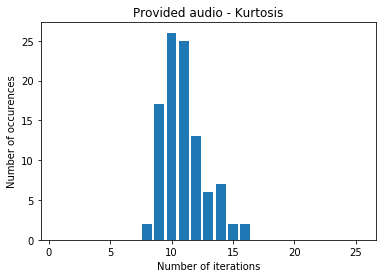

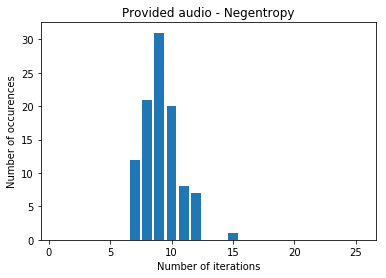

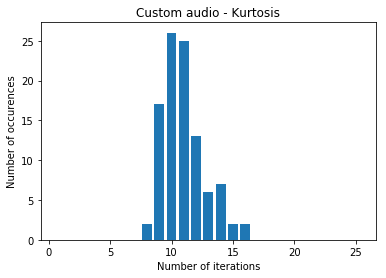

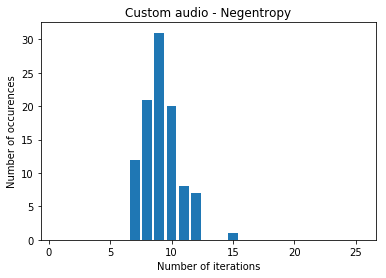

In [55]:
'''
This code may take a long time to run depending on chosen value for num_iter.

It is also somewhat sloppy written as it will crash in the unlucky case of fast_ICA getting a run of 
more than 25 iterations to reach convergence.

Uncomment code below to generate own figures. Pregenerated figures at at the bottom.
'''


import matplotlib.pyplot as plt


num_iter = 100;
x_vec = np.linspace(1,25,25)

# provided audio
num_iter_vec_kur = np.zeros(num_iter)
num_iter_vec_neg = np.zeros(num_iter)

# custom audio
num_iter_vec_kur1 = np.zeros(num_iter)
num_iter_vec_neg1 = np.zeros(num_iter)

# provided audio
y_vec_kur = np.zeros(25)
y_vec_neg = np.zeros(25)

# custom audio
y_vec_kur1 = np.zeros(25)
y_vec_neg1 = np.zeros(25)

print('finishes at: ', num_iter)
print('progress: ', end='')
for i in range(num_iter):
    # provided audio
    Z_ica_kur, W_ica_kur, num_iter_kur = fast_ICA(data, 3, kurtosis, kurtosis_d)
    Z_ica_neg, W_ica_neg, num_iter_neg = fast_ICA(data, 3, negentropy, negentropy_d)
    
    num_iter_vec_kur[i] = num_iter_kur
    num_iter_vec_neg[i] = num_iter_neg

    # custom audio
    Z_ica_kur1, W_ica_kur1, num_iter_kur1 = fast_ICA(data1, 3, kurtosis, kurtosis_d)
    Z_ica_neg1, W_ica_neg1, num_iter_kur1 = fast_ICA(data, 3, negentropy, negentropy_d)
    
    num_iter_vec_kur1[i] = num_iter_kur
    num_iter_vec_neg1[i] = num_iter_neg
    
    # provided audio
    y_vec_kur[num_iter_kur] += 1
    y_vec_neg[num_iter_neg] += 1
    
    #custom audio
    y_vec_kur1[num_iter_kur] += 1
    y_vec_neg1[num_iter_neg] += 1
    
    # progression
    print(i+1, end='')

print("Mean value of Provided audio - Kurtosis: ", np.average(y_vec_kur))
print("Mean value of Provided audio - Negentropy: ", np.average(y_vec_neg))
print("Mean value of Custom audio - Kurtosis: ", np.average(y_vec_kur1))
print("Mean value of Custom audio - Negentropy: ", np.average(y_vec_neg1))

plt.bar(x_vec, y_vec_kur)
plt.title("Provided audio - Kurtosis")
plt.xlabel("Number of iterations")
plt.ylabel("Number of occurences")
plt.savefig("pa_kur.png")
plt.show()


plt.bar(x_vec, y_vec_neg)
plt.title("Provided audio - Negentropy")
plt.xlabel("Number of iterations")
plt.ylabel("Number of occurences")
plt.savefig("pa_neg.png")
plt.show()


plt.bar(x_vec, y_vec_kur1)
plt.title("Custom audio - Kurtosis")
plt.xlabel("Number of iterations")
plt.ylabel("Number of occurences")
plt.savefig("ca_kur.png")
plt.show()

plt.bar(x_vec, y_vec_neg1)
plt.title("Custom audio - Negentropy")
plt.xlabel("Number of iterations")
plt.ylabel("Number of occurences")
plt.savefig("ca_neg.png")
plt.show()

![title](pa_kur.png)
![title](pa_neg.png)
![title](ca_kur.png)
![title](ca_neg.png)

pre-saved pdf files showing bar diagrams of kurtosis and negentropy can be used to determine which of the two are "fastest"

<h2>References</h2>
    <a id="pb" href="#pb"><sup>1</sup></a> B. Owren, TMA4320 – våren 2019, Prosjekt 1: Blind source separation, 2019<br/>
    <a id="article" href="#article"><sup>2</sup></a> A. Hyvärinen and E. Oja, Independent component analysis: algorithms and applications, Neural networks 13 (2000) 411–413.